In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# RQ1: Which technologies have been investigated in the last decade?

In [3]:
data = pd.read_csv('./data/500se.csv')
data.head()

,Cites,Authors,Title,Year,Source,Publisher,ArticleURL,CitesURL,GSRank,QueryDate,...,Volume,Issue,StartPage,EndPage,ECC,CitesPerYear,CitesPerAuthor,AuthorCount,Age,Abstract
0,7653,"C Wohlin, P Runeson, M Höst, MC Ohlsson, B Reg...",Experimentation in software engineering,2012,NaN,books.google.com,https://books.google.com/books?hl=en&lr=&id=QP...,https://scholar.google.com/scholar?cites=11975...,1,2021-05-11 13:03:30,...,NaN,NaN,NaN,NaN,7653,850.33,1276,6,9,Like other sciences and engineering discipline...
1,441,R Mall,Fundamentals of software engineering,2018,NaN,books.google.com,https://books.google.com/books?hl=en&lr=&id=-J...,https://scholar.google.com/scholar?cites=22762...,2,2021-05-11 13:03:30,...,NaN,NaN,NaN,NaN,441,147.00,441,1,3,"This new edition of the book, is restructured ..."
2,698,P Jalote,An integrated approach to software engineering,2012,NaN,books.google.com,https://books.google.com/books?hl=en&lr=&id=Hi...,https://scholar.google.com/scholar?cites=65505...,3,2021-05-11 13:03:30,...,NaN,NaN,NaN,NaN,698,77.56,698,1,9,A lot has changed in the fast-moving area of s...
3,1051,"N Juristo, AM Moreno",Basics of software engineering experimentation,2013,NaN,books.google.com,https://books.google.com/books?hl=en&lr=&id=iJ...,https://scholar.google.com/scholar?cites=81867...,4,2021-05-11 13:03:30,...,NaN,NaN,NaN,NaN,1051,131.38,526,2,8,Basics of Software Engineering Experimentation...
4,491,"NMA Munassar, A Govardhan",A comparison between five models of software e...,2010,International Journal of Computer Science …,Citeseer,http://citeseerx.ist.psu.edu/viewdoc/download?...,https://scholar.google.com/scholar?cites=70840...,5,2021-05-11 13:03:30,...,NaN,NaN,NaN,NaN,491,44.64,246,2,11,This research deals with a vital and important...


In [4]:
def CreateTermDocMatrix(column):
        
    count_vectorizer = CountVectorizer(stop_words='english',ngram_range = (1,2))
    sparse_matrix = count_vectorizer.fit_transform(data[column].values.astype('U'))

    doc_term_matrix = sparse_matrix.todense()
    df = pd.DataFrame(doc_term_matrix, columns=count_vectorizer.get_feature_names())
    df['PublishingYear'] = data['Year']
    returndf = df.groupby('PublishingYear').sum().transpose()
    return returndf

In [5]:
def ShowWord(data,word):
    d = data.loc[word]
    d.plot.bar()

In [6]:
def SpaltenEntf(data):
    y = []
    for item in data.columns:
        y = data.columns


    for index in range(len(y)):
        x = y[index]
        if x in stopwords or x.isnumeric():
            del data[y[index]]
    return data

PublishingYear        2009  2010  2011  2012  2013  2014  2015  2016  2017  \
challenges               6     4     8     3     3     5     1     1     7   
development             19    24    14    13    15     5    13    11     8   
engineering             52    69    57    46    61    35    31    36    17   
software               102   134    92    80    92    66    59    62    39   
software development     8    15     7     9     7     2     9     6     6   
software engineering    37    64    50    39    55    31    28    32    13   

PublishingYear        2018  2019  2020  2021  
challenges               0     0     0     0  
development              4     1     1     3  
engineering             19     1     2     1  
software                25     3     2     5  
software development     2     0     0     3  
software engineering    15     1     2     1  


(6, 13)

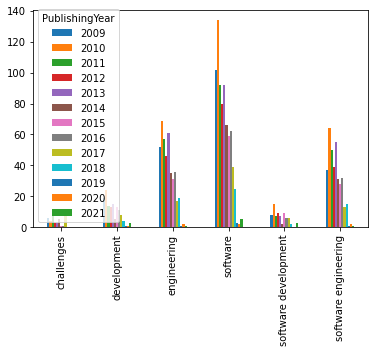

In [7]:
#Untersuchung Abstract

abstract = CreateTermDocMatrix('Abstract')

b = abstract.loc[abstract[2017] > 5] 

b.plot.bar()
print(b)
b.shape


In [8]:
#Untersuchung Title
title = CreateTermDocMatrix('Title')

print(title)
#title = SpaltenEntf(title)
print(title)

b = title.loc[title[2017] > 5] 

b.plot.bar()
print(b)
#b.shape


PublishingYear   2009  2010  2011  2012  2013  2014  2015  2016  2017  2018  \
10                  1     0     0     0     0     0     0     0     0     0   
10 practices        1     0     0     0     0     0     0     0     0     0   
100                 0     0     0     0     0     0     0     1     0     0   
15                  0     0     0     0     0     1     0     0     0     0   
15 objectives       0     0     0     0     0     1     0     0     0     0   
...               ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
wrong               0     0     0     0     0     0     0     0     0     1   
wrong topic         0     0     0     0     0     0     0     0     0     1   
years               0     0     1     0     0     0     0     1     0     0   
years component     0     0     0     0     0     0     0     1     0     0   
years search        0     0     1     0     0     0     0     0     0     0   

PublishingYear   2019  2020  2021  
10             

NameError: name 'stopwords' is not defined

In [ ]:
#Einzelnes Wort anzeigen
abstract = CreateTermDocMatrix('Abstract')
ShowWord(abstract,'software')